#Dataset Description

##Preprocessed data taken from a study done by Nanyang Technological University Singapore

https://arxiv.org/abs/2106.00613



# Load Dataset from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from scipy.io import loadmat
import numpy as np

# Path to the .mat file on your Google Drive
mat_file_path = '/content/drive/MyDrive/Capstone/dataset.mat'

# Load the .mat file
mat_data = loadmat(mat_file_path)


In [ ]:
EEGsample = mat_data['EEGsample']
subindex = mat_data['subindex']
substate = mat_data['substate']

# Build the Transformer Model

In [ ]:
import numpy as np
import tensorflow as tf
from keras import layers, Model

def get_positional_encoding(seq_length, d_model):
    position = np.arange(seq_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_enc = np.zeros((seq_length, d_model))
    pos_enc[:, 0::2] = np.sin(position * div_term)
    pos_enc[:, 1::2] = np.cos(position * div_term)

    return tf.convert_to_tensor(pos_enc[..., np.newaxis], dtype=tf.float32)

class PositionalEncoding(layers.Layer):
    def __init__(self, seq_length, d_model):
        super().__init__()
        self.pos_encoding = get_positional_encoding(seq_length, d_model)

    def call(self, inputs):
      return inputs + tf.squeeze(self.pos_encoding, axis=2)

class MultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, d_model, dropout_rate):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.dropout_rate = dropout_rate
        self.depth = d_model // num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dropout = layers.Dropout(dropout_rate)
        self.dense = layers.Dense(d_model)

    def split_heads(self, x):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (-1, x.shape[1], self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]

        # Linear layers
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # Split heads
        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        # Scale dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Masking
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Softmax
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        # Dropout
        attention_weights = self.dropout(attention_weights)

        # Context vector
        output = tf.matmul(attention_weights, v)

        # Concatenate heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))

        # Final linear layer
        output = self.dense(output)

        return output

class FeedForward(layers.Layer):
    def __init__(self, d_model, dff, name="feedforward"):
        super(FeedForward, self).__init__(name=name)
        self.dense1 = layers.Dense(dff, activation='relu')
        self.dense2 = layers.Dense(d_model)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return x

class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name="encoder_layer"):
        super(EncoderLayer, self).__init__(name=name)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = FeedForward(d_model, dff)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.mha(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        output = self.layernorm2(out1 + ffn_output)
        return output

class EEGTransformer(Model):
    def __init__(self, seq_length, d_model, num_heads, num_layers, num_classes, dff, dropout_rate):
        super().__init__()
        self.conv1d = layers.Conv1D(d_model, kernel_size=25, padding='same', activation='relu')
        self.positional_encoding = PositionalEncoding(seq_length, d_model)
        self.encoder_layers = [EncoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(dropout_rate)
        self.global_average_pooling = layers.GlobalAveragePooling1D()
        self.classification_layer = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training):
        x = self.positional_encoding(inputs)
        x = self.conv1d(x)
        for i in range(len(self.encoder_layers)):
            x = self.encoder_layers[i](x, training)
        x = self.dropout(x, training=training)
        x = self.global_average_pooling(x)
        output = self.classification_layer(x)
        return output

In [ ]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
# Instantiate the model
model = EEGTransformer(
    seq_length=384,
    d_model=16,
    num_heads=4,
    num_layers=2,
    num_classes=2,
    dff=64,
    dropout_rate=0.3
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Split and Train the Data

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tabulate import tabulate
import matplotlib.pyplot as plt

Processing subject 1


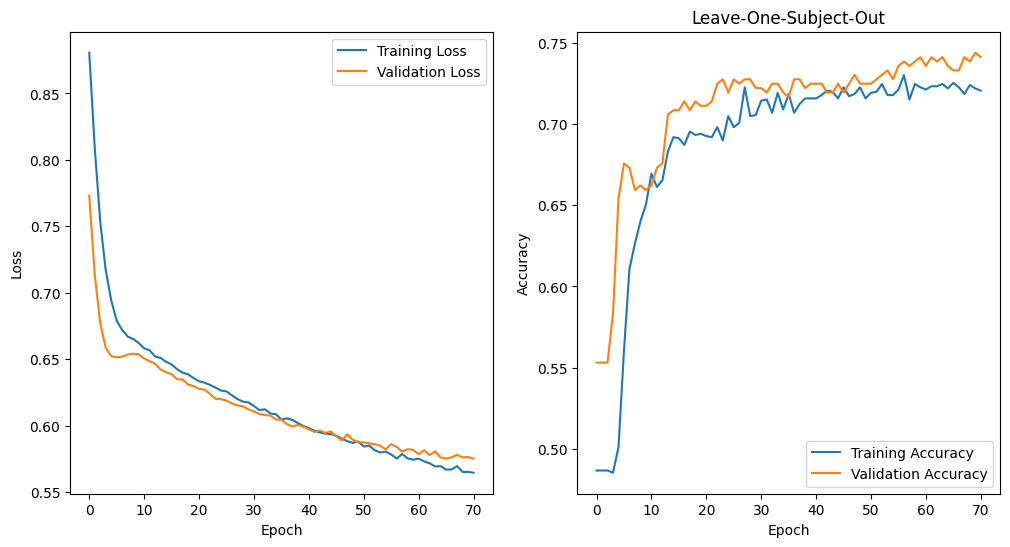

test


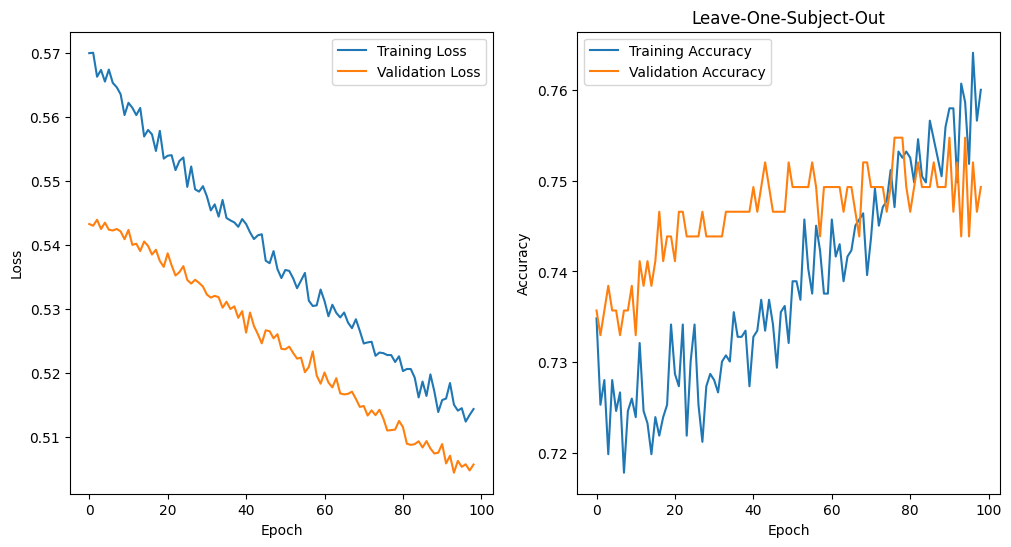

test


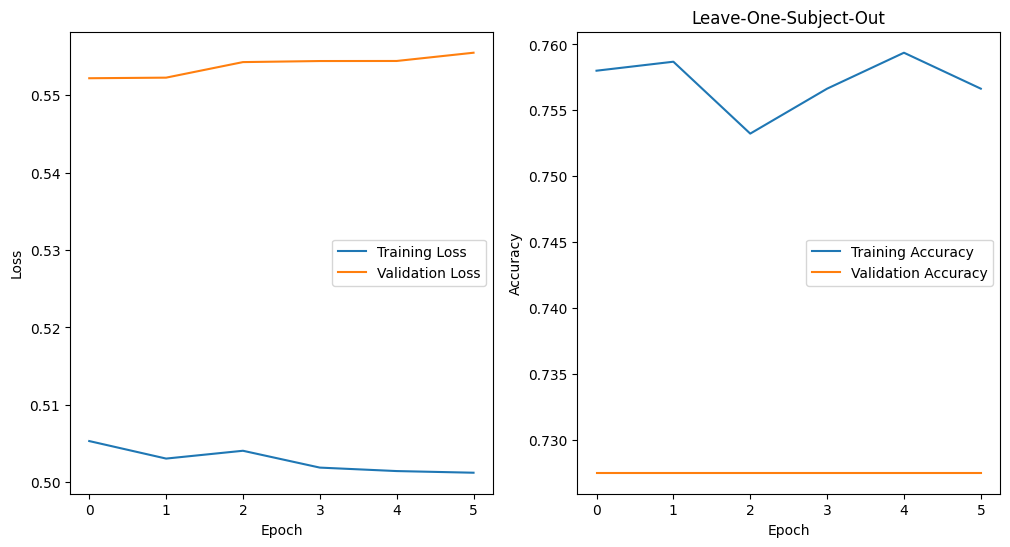

test


KeyboardInterrupt: ignored

In [ ]:
# Define the channel names
channel_names = {
    4: "Fz",
    9: "FCz",
    14: "Cz",
    19: "CPz",
    24: "Pz",
    28: "Oz"
}


iter = 3

# Iterate through all patient IDs
for patient_id in range(1, 12):  # Assuming there are 11 patients with IDs from 1 to 11
    print(f"Processing subject {patient_id}")

    # Combine data from all subjects except the test_patient_id
    train_patient_mask = subindex != patient_id
    test_patient_mask = subindex == patient_id
    X_train_all = EEGsample[np.squeeze(train_patient_mask)]
    y_train_all = substate[np.squeeze(train_patient_mask)]

    X_test_all = EEGsample[np.squeeze(test_patient_mask)]
    y_test_all = substate[np.squeeze(test_patient_mask)]
    # print(f"Size of test subject: {X_test_all.shape} ")
    # print(f"Size of every other subject: {X_train_all.shape} ")


    # Initialize an empty dictionary to store the test accuracies for each channel
    channel_accuracies = {}
    # Initialize an empty dictionary to store the losses for each channel
    channel_losses = {}


    # Loop through the channel indices
    for channel_name in channel_names:
        # Initialize lists to store the train, validation, and test accuracies for the current channel
        train_accuracies = []
        val_accuracies = []
        test_accuracies = []
        train_losses = []
        val_losses = []
        test_losses = []
        f1_scores = []
        roc_aucs = []

        model = EEGTransformer(
                seq_length=384,
                d_model=16,
                num_heads=4,
                num_layers=2,
                num_classes=2,
                dff=64,
                dropout_rate=0.3
            )

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.00001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

        for i in range(iter):

            # Extract the current channel data
            X_train_channel = X_train_all[:, channel_name, :]
            X_train_channel = np.expand_dims(X_train_channel, axis=-1)
            X_test_channel = X_test_all[:, channel_name, :]
            X_test_channel = np.expand_dims(X_test_channel, axis=-1)

            # Assuming x_normalized contains the preprocessed (normalized) epochs
            X_train_tensor = tf.convert_to_tensor(X_train_channel, dtype=tf.float32)
            X_test_tensor = tf.convert_to_tensor(X_test_channel, dtype=tf.float32)

            # Assuming y contains the sleep stage labels
            y_train_tensor = tf.convert_to_tensor(y_train_all, dtype=tf.int32)
            y_test_tensor = tf.convert_to_tensor(y_test_all, dtype=tf.int32)

            # Split the training data into training (80%) and validation (20%) sets
            X_train, X_val, y_train, y_val = train_test_split(X_train_tensor.numpy(), y_train_tensor.numpy(), test_size=0.2)

            X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
            y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
            X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
            y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)

            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
            val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
            test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_tensor))


            batch_size = 64
            buffer_size = len(X_train)

            train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
            val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
            test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

            # Train the model
            epochs = 100

            # Early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            history = model.fit(
                train_dataset,
                validation_data=val_dataset,
                epochs=epochs,
                callbacks=[early_stopping],
                verbose=0
            )



            # Get the training and validation accuracies and losses from the history object
            train_accuracy = history.history['accuracy'][-1]
            val_accuracy = history.history['val_accuracy'][-1]
            train_loss = history.history['loss'][-1]
            val_loss = history.history['val_loss'][-1]

            # Evaluate the model on the test set
            test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

            #Get the F1 score
            # Generate predictions on the test dataset
            y_pred = model.predict(test_dataset, verbose = 0)
            y_pred_classes = np.argmax(y_pred, axis=-1)

            # Flatten the tensors to 1D arrays for plotting
            y_test_array = y_test_tensor.numpy().flatten()
            y_pred_array = y_pred_classes.flatten()
            f1 = f1_score(y_test_array, y_pred_array)

            # Compute the predicted probabilities of the positive class
            y_pred_probs = y_pred[:, 1]

            # Compute the AUC-ROC
            roc_auc = roc_auc_score(y_test_array, y_pred_probs)

            # Append the accuracies and losses to their respective lists
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            test_accuracies.append(test_accuracy)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            test_losses.append(test_loss)
            f1_scores.append(f1)
            roc_aucs.append(roc_auc)

        # Compute the average accuracies and losses for the current channel
        avg_train_accuracy = np.mean(train_accuracies)
        avg_val_accuracy = np.mean(val_accuracies)
        avg_test_accuracy = np.mean(test_accuracies)
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        avg_test_loss = np.mean(test_losses)
        avg_f1_score = np.mean(f1_scores)
        avg_roc_auc = np.mean(roc_aucs)


        # Store the average accuracies and losses in the dictionaries
        channel_accuracies[channel_name] = {
            'train': avg_train_accuracy,
            'val': avg_val_accuracy,
            'test': avg_test_accuracy,
            'f1': avg_f1_score,
            'roc_auc': avg_roc_auc
        }
        channel_losses[channel_name] = {
            'train': avg_train_loss,
            'val': avg_val_loss,
            'test': avg_test_loss
        }

        # print(f"Channel {channel_index} average accuracies:")
        # print(f"  Train: {avg_train_accuracy:.4f}")
        # print(f"  Validation: {avg_val_accuracy:.4f}")
        # print(f"  Test: {avg_test_accuracy:.4f}")

    # Print the accuracies and losses for all channels
    print(f"Subject {patient_id} channel accuracies and losses:")

    # Prepare the table data
    table_data = []
    for channel, accuracies in channel_accuracies.items():
        losses = channel_losses[channel]
        channel_name = channel_names.get(channel, "Unknown")
        table_data.append([
            channel,
            channel_name,
            f"{accuracies['train']:.4f}",
            f"{losses['train']:.4f}",
            f"{accuracies['val']:.4f}",
            f"{losses['val']:.4f}",
            f"{accuracies['test']:.4f}",
            f"{losses['test']:.4f}",
            f"{accuracies['f1']:.4f}",
            f"{accuracies['roc_auc']:.4f}",
        ])

    # Sort the table data by test accuracy in descending order
    table_data.sort(key=lambda row: float(row[-2]), reverse=True)

    # Define the table headers
    headers = [
        "Channel",
        "Name",
        "Train Accuracy",
        "Train Loss",
        "Validation Accuracy",
        "Validation Loss",
        "Test Accuracy",
        "Test Loss",
        "F1 Score",
        "ROC-AUC",
    ]

    # Print the table
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    print("\n")



In [ ]:
            # Plot training and validation accuracy
            ax2.plot(train_acc, label='Training Accuracy')
            ax2.plot(val_acc, label='Validation Accuracy')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy')
            ax2.legend()
            ax2.set_title('Leave-One-Subject-Out W/O 1DCNN')


Text(0.5, 1.0, 'Leave-One-Subject-Out W/O 1DCNN')

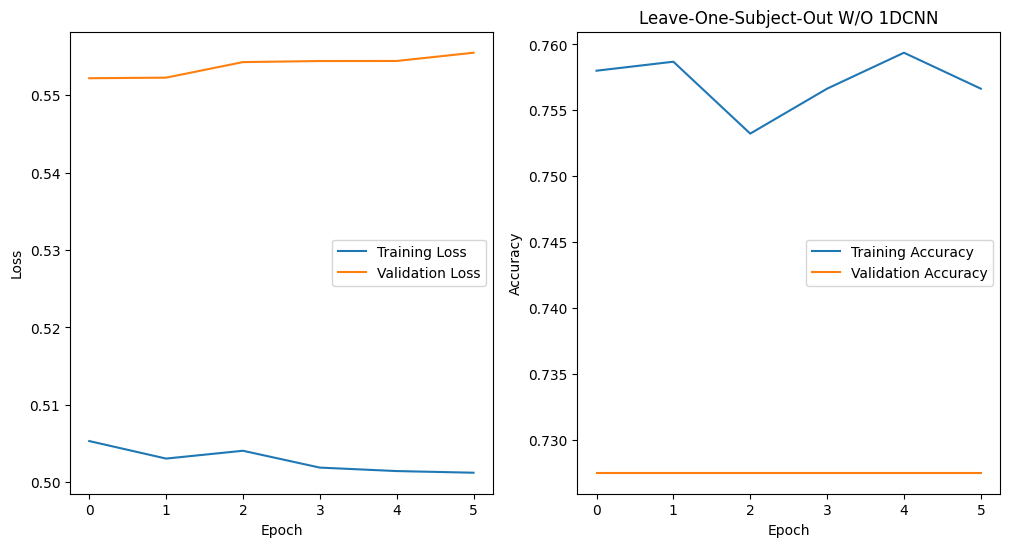

In [ ]:

            # Get training and validation loss
            train_loss = history.history['loss']
            val_loss = history.history['val_loss']

            # Get training and validation accuracy
            train_acc = history.history['accuracy']
            val_acc = history.history['val_accuracy']

            # Create subplots for loss and accuracy
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

            # Plot training and validation loss
            ax1.plot(train_loss, label='Training Loss')
            ax1.plot(val_loss, label='Validation Loss')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.legend()

            # Plot training and validation accuracy
            ax2.plot(train_acc, label='Training Accuracy')
            ax2.plot(val_acc, label='Validation Accuracy')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy')
            ax2.legend()
            ax2.set_title('Leave-One-Subject-Out W/O 1DCNN')

            # Show the plot
            plt.show()
